In [2]:
import torch
import torch.nn as nn
import torch.jit

# 定义一个简单的模型
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

# 实例化模型并移动到正确的设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleModel().to(device)

# 创建输入张量
input_tensor = torch.randn(1, 1, 28, 28, device=device)

# 使用 torch.jit.trace 跟踪模型
traced_model = torch.jit.trace(model, input_tensor)

# 保存 traced 模型
traced_model.save("simple_model_traced.pt")

# 加载并使用 traced 模型
loaded_model = torch.jit.load("simple_model_traced.pt")
output = loaded_model(input_tensor)


In [2]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [3]:
# Load an image
img = cv2.imread('/home/hh/Documents/train/00031546.jpg')[:, :, ::-1]
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}
print(device)
# Load the model
ckpt = '../weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

cuda


In [4]:
# 创建输入张量
#inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}

# 使用 torch.jit.trace 跟踪模型
traced_model = torch.jit.script(net, inputs)

# 保存 traced 模型
traced_model.save("Deep_LSD.pt")

/home/hh/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/jit/_script.py:1223: UserWarning: `optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead
  "`optimize` is deprecated and has no effect. Use `with torch.jit.optimized_execution() instead"
[W ir_emitter.cpp:4257] Warning: List consists of heterogeneous types, which means that it has been typed as containing Union[__torch__.torch.nn.modules.container.___torch_mangle_12.Sequential, __torch__.torch.nn.modules.container.___torch_mangle_4.Sequential, __torch__.torch.nn.modules.container.___torch_mangle_8.Sequential]. To use any of the values in this List, it will be necessary to add an `assert isinstance` statement before first use to trigger type refinement.
  File "/home/hh/Documents/DeepLSD/deeplsd/models/backbones/vgg_unet.py", line 86
        # Encoding
        features = [self.block1(inputs)]
        for block in [self.block2, self.block3, self.block4]:
                     ~~~~~~~~

RuntimeError: 
cannot call a value of type 'Union[__torch__.torch.nn.modules.container.___torch_mangle_12.Sequential, __torch__.torch.nn.modules.container.___torch_mangle_4.Sequential, __torch__.torch.nn.modules.container.___torch_mangle_8.Sequential]':
  File "/home/hh/Documents/DeepLSD/deeplsd/models/backbones/vgg_unet.py", line 87
        features = [self.block1(inputs)]
        for block in [self.block2, self.block3, self.block4]:
            features.append(block(self.pool(features[-1])))
                            ~~~~~ <--- HERE
    
        # Decoding


RecursiveScriptModule(
  original_name=DeepLSD
  (backbone): RecursiveScriptModule(
    original_name=VGGUNet
    (pool): RecursiveScriptModule(original_name=AvgPool2d)
    (block1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=BatchNorm2d)
      (3): RecursiveScriptModule(original_name=Conv2d)
      (4): RecursiveScriptModule(original_name=ReLU)
      (5): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (block2): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=ReLU)
      (2): RecursiveScriptModule(original_name=BatchNorm2d)
      (3): RecursiveScriptModule(original_name=Conv2d)
      (4): RecursiveScriptModule(original_name=ReLU)
      (5): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (block3

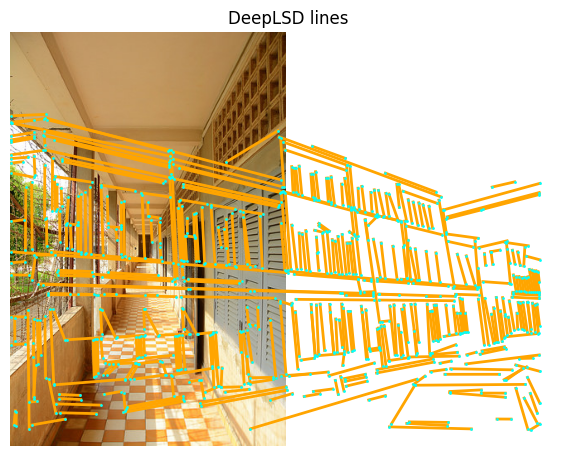

In [13]:
import torch
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# 加载 TorchScript 模型
model = torch.jit.load('DeepLSD.pt')

import time
# 记录开始时间
start_time = time.time()
# 打印模型结构（可选）
print(model)

inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
# 将输入数据移到模型相同的设备（CPU 或 GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# 确保模型处于评估模式
model.eval()

# 运行模型
with torch.no_grad():
    output = model(inputs)

# 打印输出
print(output)

end_time = time.time()

pred_lines = (output.numpy())[0]
# 计算并打印运行时间
inference_time = end_time - start_time
print(f"Network inference time: {inference_time:.4f} seconds") 
# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

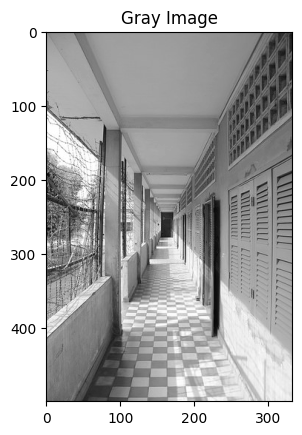

In [10]:
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')
plt.show()